In [1]:
%matplotlib inline

from preprocess import *
from utils import *
import TemporalClusterer as tc
import numpy as np
import pandas as pd
import datetime

import umap
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.cluster.hierarchy import dendrogram, linkage

import sys
import os


In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

In [ ]:
## Settings
## Variables for analysis
This notebook contains pre analysis of data of security events. It is intended to be used for reasoning about why during final  analysis majority of data are dropped. And why such choices were made.

In [3]:
thresh=10 # Minimal amount of events for IP required 
act_threshold=4 # Minimal time slot activity required
aggr=15*60 # Aggregation window in seconds - default 15 minutes

data='Z:/SECT/' # Dataset location

In [4]:
file_list = [x.date().isoformat() for x in pd.date_range('2020-02-08', '2020-02-15')]
days = len(file_list)

df = pd.DataFrame()
for file_name in file_list:
    df = pd.concat([df, pd.read_pickle(data + file_name + '.pcl')], ignore_index=True)

df.head()

,ip,timestamp,origin,type,line
0,5.188.86.169,1581116394,[{'SW': ['Cowrie with Warden Filer output modu...,['Intrusion.UserCompromise'],0
1,185.209.0.64,1581116358,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",475
2,47.176.15.90,1581116359,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",1071
3,185.156.177.22,1581116362,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",1667
4,66.196.219.2,1581116357,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",2266


In [5]:
tfrom = datetime.datetime.fromisoformat('{} 00:00:00'.format(file_list[0])).timestamp()
tto = datetime.datetime.fromisoformat('{} 23:59:59'.format(file_list[-1])).timestamp()

df = df.loc[(df['timestamp'] >= tfrom) & (df['timestamp'] < tto), :]
df['slot']= ((df['timestamp']-tfrom)/aggr).astype(np.int) # which aggregation window does it belong to

df.head()

,ip,timestamp,origin,type,line,slot
9,185.197.74.246,1581119994,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",5187,3
255,5.188.62.13,1581116407,[{'SW': ['Cowrie with Warden Filer output modu...,['Intrusion.UserCompromise'],229518,0
257,5.182.39.96,1581116403,[{'SW': ['Cowrie with Warden Filer output modu...,['Intrusion.UserCompromise'],230977,0
259,5.188.86.219,1581116409,[{'SW': ['Cowrie with Warden Filer output modu...,['Intrusion.UserCompromise'],232847,0
314,5.188.87.51,1581120004,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",271133,4


## Features extracted here

In [6]:
dfip = pd.DataFrame()
dfip['list'] = df.groupby('ip')['slot'].agg(lambda x: (list(x))) # List of all time slots IP communicated in, with duplicity

dfip['count'] = dfip.list.apply(list.__len__) # count of eventf for IP

dfip['series'] = dfip.list.apply(get_bin_series, args=[np.ceil((days*24*3600)/aggr)]) # as list, but in form of binary vector
dfip['blocks'] = dfip.series.apply(count_blocks) # number of continuous trute values in series vector (we favor more segmented) 
dfip['activity'] = dfip.series.apply(np.sum) # number of slots in wich events where detected

,list,count,series,blocks,activity,class
ip,,,,,,
1.0.0.24,"[212, 214, 334, 348, 539, 680, 717]",7,"[False, False, False, False, False, False, Fal...",7,7,small
1.0.128.207,[303],1,"[False, False, False, False, False, False, Fal...",1,1,small
1.0.130.113,"[40, 71, 74, 83, 90]",5,"[False, False, False, False, False, False, Fal...",5,5,small
1.0.130.79,"[65, 76]",2,"[False, False, False, False, False, False, Fal...",2,2,small
1.0.131.152,"[202, 202]",2,"[False, False, False, False, False, False, Fal...",1,1,small


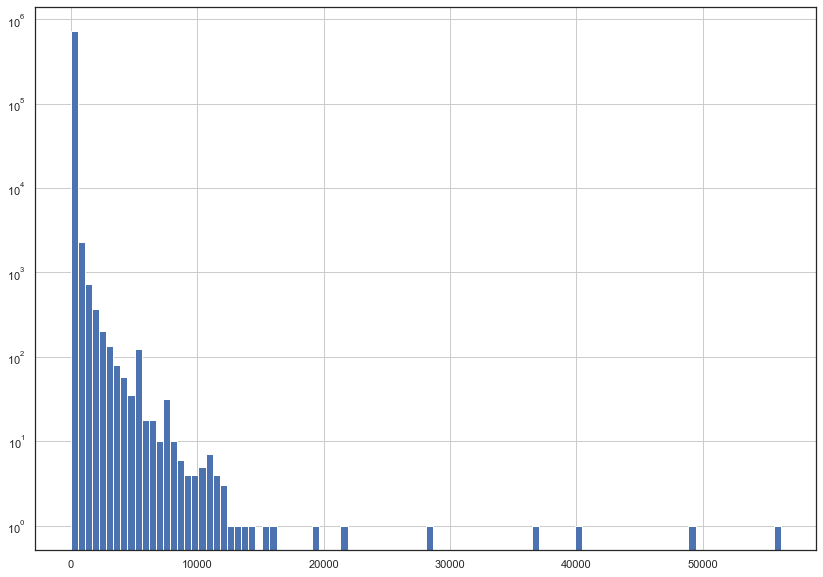

In [7]:
#mark separate classes

dfip['class'] = dfip['activity'].apply(lambda x: 'small' if x < act_threshold 
                                    else 'too much' if x > 0.7*np.ceil((days*24*3600)/aggr) 
                                    else 'good')

dfip['class'] = dfip['count'].apply(lambda x: 'small' if x < days 
                                    else 'too much' if x > days*1000
                                    else 'good')

dfip['count'].hist(bins=100)
plt.yscale('log')
dfip.head()

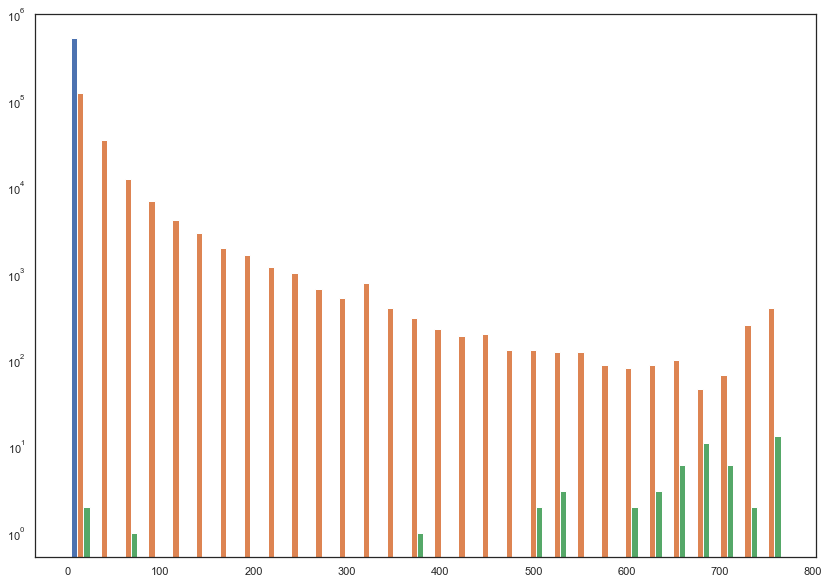

In [8]:
plt.hist([dfip.loc[dfip['class']==x,"activity"] for x in ['small','good','too much']], bins=30)
plt.yscale('log')

In [9]:
print("IP count reduction when count threshold is set to {}\n ratio {}\n ip count {}"
      .format(days, 
              len(dfip.loc[dfip['class']=='good', 'activity'])/len(dfip['activity']),
              len(dfip.loc[dfip['class']=='good'])))

IP count reduction when count threshold is set to 8
 ratio 0.2699197316566475
 ip count 195542


C:\Users\istoffa\.conda\envs\cesnet-ml\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


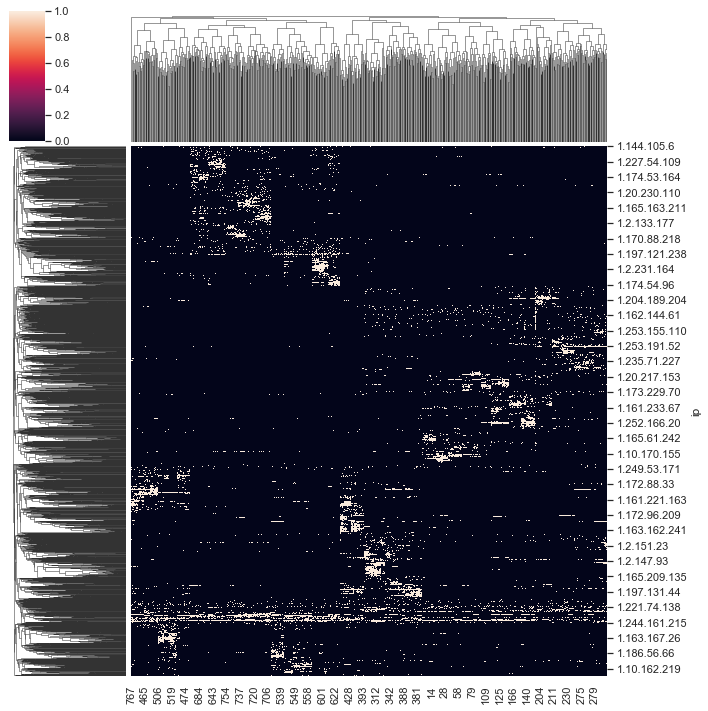

In [10]:
dfipgood=dfip.loc[dfip['class']=='good','series']

act = pd.DataFrame(data=np.stack(dfipgood), index=dfipgood.index)
sns.clustermap(act.head(2000), metric='jaccard')

This is activity clusters of first 2000 ips

In [11]:
##Dokoncit ... pointa je, aby bolo vysvetlene filtrovanie dat
act['ip']=act.index
exmatch=act.groupby(list(range(0,np.int((days*24*3600)/aggr)))).agg([list, 'count'])

print(len(exmatch.loc[exmatch['ip']['count']>1,:])/len(dfip))

0.005213646308553445


In [12]:
print(len(exmatch)/len(dfip))

0.2603206592632981


3777
0.20    1.0
0.80    1.0
0.95    1.0
0.99    2.0
Name: count, dtype: float64
                   0      1      2      3      4      5      6      7    \
list                                                                      
113.160.251.252  False  False  False  False  False  False  False  False   
150.136.236.53   False  False  False  False  False  False  False  False   
125.214.58.62    False  False  False  False  False  False  False  False   
14.231.149.222   False  False  False  False  False  False  False  False   
117.58.243.84    False  False  False  False  False  False  False  False   

                   8      9    ...    758    759    760    761    762    763  \
list                           ...                                             
113.160.251.252  False  False  ...  False  False  False  False  False  False   
150.136.236.53   False  False  ...  False  False  False  False  False  False   
125.214.58.62    False  False  ...  False  False  False  False  False   T

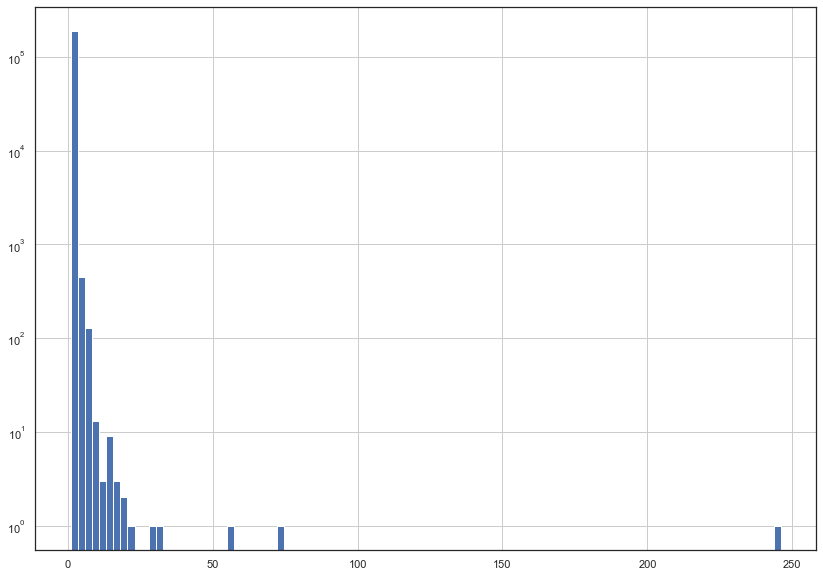

In [13]:
exmatch['ip']['count'].hist(bins=100, log=True)
print(len(exmatch.loc[exmatch['ip']['count']>1,:]))

exmatch.loc[exmatch['ip']['count']>1,:]
print(exmatch['ip']['count'].quantile([0.2,0.8,0.95,0.99]))

gact=pd.DataFrame(data=np.stack(exmatch.loc[exmatch['ip']['count']>1,:].index.to_flat_index()), 
                  index=exmatch.loc[exmatch['ip']['count']>1,:]['ip']['list'].apply(lambda x: x[0]))

print(gact.head())

C:\Users\istoffa\.conda\envs\cesnet-ml\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


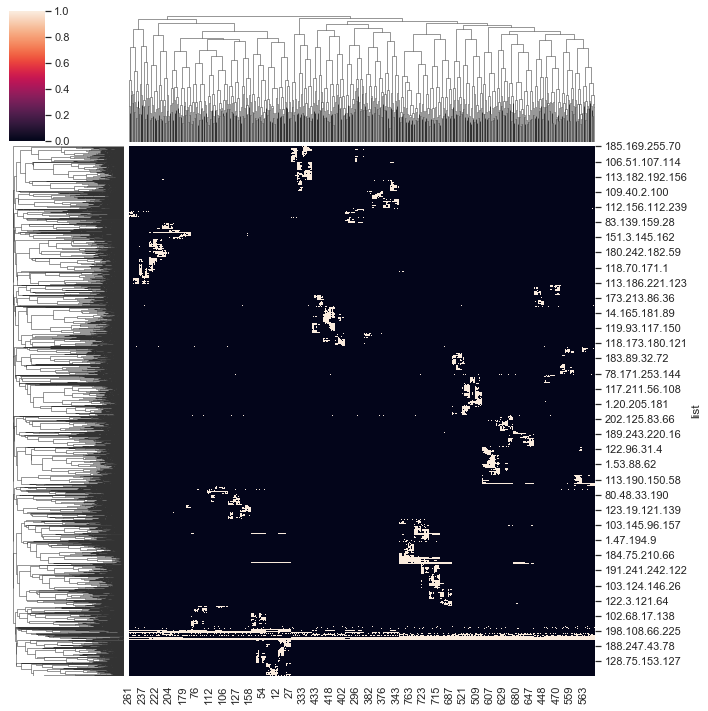

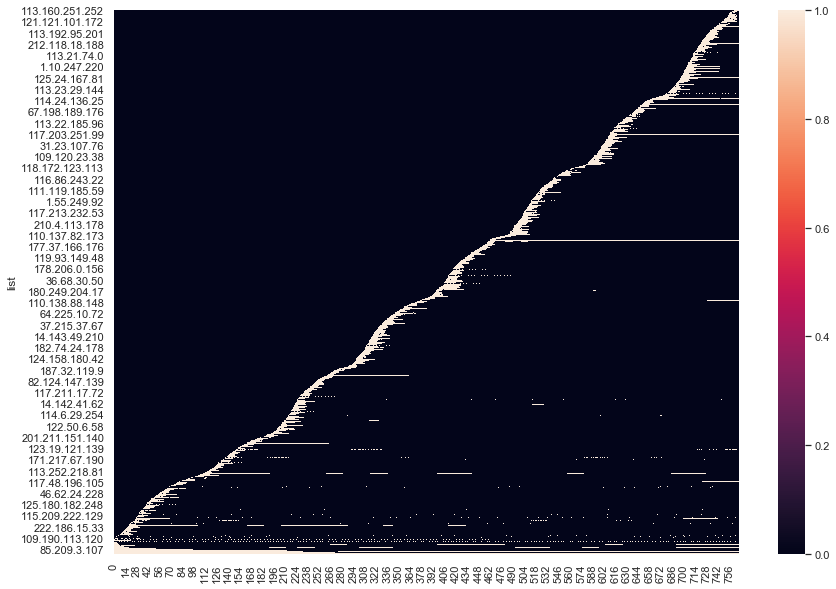

In [14]:
sns.clustermap(gact, metric='jaccard')
plt.figure()
sns.heatmap(gact)

                ip
             count
count  3777.000000
mean      2.841144
std       4.516058
min       2.000000
25%       2.000000
50%       2.000000
75%       3.000000
max     246.000000
             count       blocks     activity
count  3777.000000  3777.000000  3777.000000
mean     50.254964     2.397405    20.384432
std     256.428660    11.208403    53.169525
min       8.000000     0.000000     1.000000
25%      10.000000     1.000000     9.000000
50%      12.000000     1.000000    12.000000
75%      18.000000     1.000000    16.000000
max    6156.000000   260.000000   768.000000


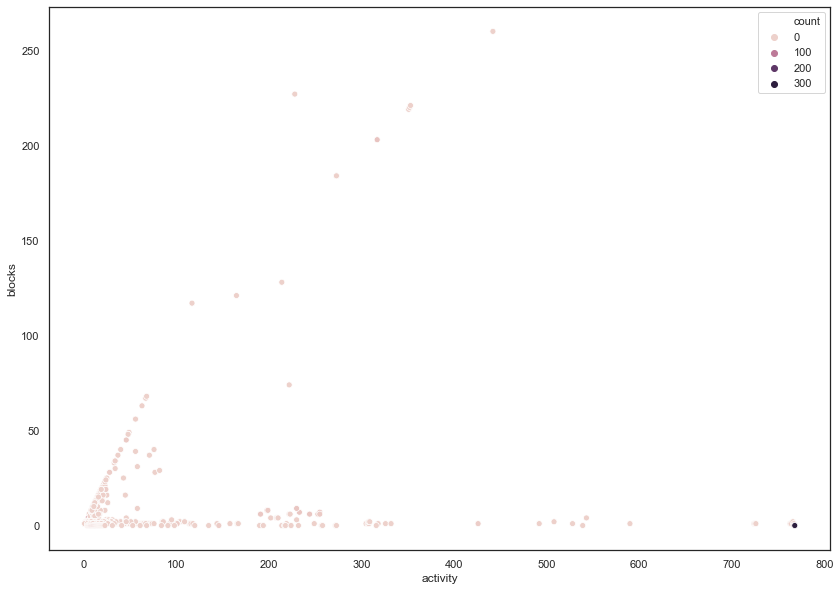

In [15]:
ipexmatch=exmatch.copy()
ipexmatch.index=exmatch['ip']['list'].apply(lambda x: x[0])
sns.scatterplot(data=dfip.loc[gact.index,:],y='blocks',x='activity',hue=ipexmatch.loc[gact.index,'ip']['count'])
#this is quite interesting
print(ipexmatch.loc[gact.index,:].describe())
print(dfip.loc[gact.index,:].describe())



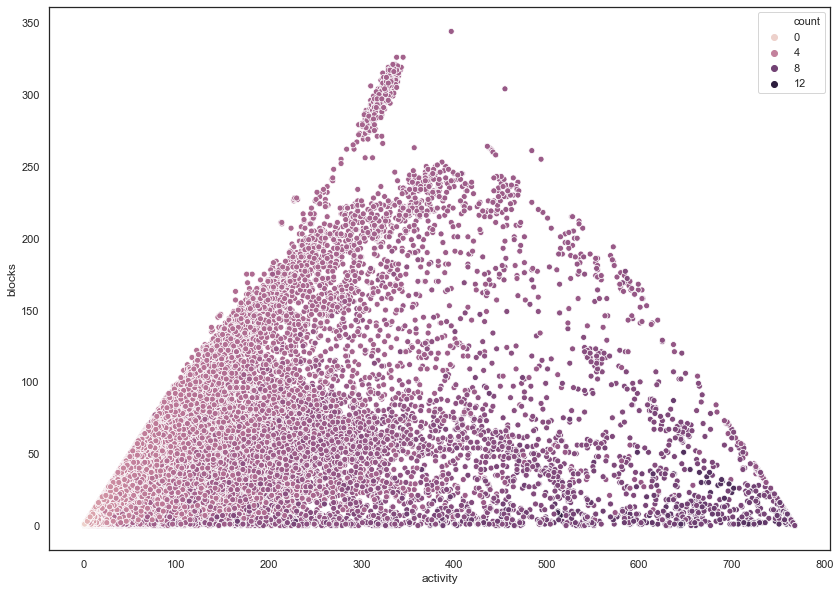

In [16]:
sns.scatterplot(data=dfip,y='blocks',x='activity', hue=dfip['count'].apply(np.log))

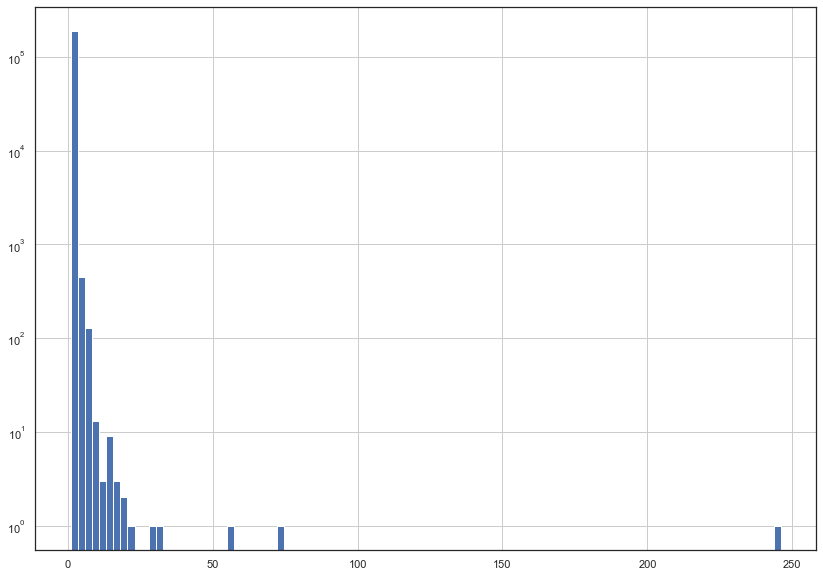

In [17]:
exmatch['ip']['count'].hist(log=True, bins=100)

In [18]:
test = pd.DataFrame(data=np.stack(exmatch.index.to_flat_index()), index=exmatch[:])

ctest.index=range(0,len(ctest))
cg=sns.clustermap(ctest.sample(2000), metric='jaccard')

groups = pd.DataFrame(data=exmatch.values)
groups['size'] = groups.apply(lambda x: len(x[0]), axis=1)

groups.index=groups[0].apply(lambda x: x[0])
groups['activity']=dfip['activity']

NameError: name 'ctest' is not defined

In [ ]:
groups['size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>1, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>2, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>act_threshold, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>20, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>100, 'size'].hist(bins=list(range(0,800,8)))

#groups.loc[(groups['activity']>act_threshold)&(groups['size']>15), 'size'].hist(bins=list(range(0,800,8)))

plt.yscale('log')

Predošlý graf je zaujímavý. Ukazuje, ako sa lýšia veľkosti klastrov (presné zhody) a ich rozloženie. 
Ak sa okrem veľkosti grafov vezme do úvahy aj minimálna aktivita (náhodnosť klesá), vidno rozkol v distribúcií.

Pravdepodobne, nízka miera aktivity vedie na veľké množstvo náhodných korelácií, veľké skupiny (modrá)
Artefakty ? Ako by mohli vyzerať ? Ako filtrovať ? 
Graf je dekomponavaný podľa aktivity (počet slotov kde sa komnunikovalo)

modré su náhodné korelácie (x je počet v skupine s presnou zhodou)
Rationale - s počtom slotov aktivity rastie priestor v kt. sa IP môzu rozprestireť, pst. náhodnej korelacie klesá. 
!!!

In [ ]:
act['ip']=act.index
act = act.loc[dfip['count']>1]
exmatch=act.groupby(list(range(0,np.int((days*24*3600)/aggr)))).agg(list)
print(len(exmatch)/len(act))

test = pd.DataFrame(data=np.stack(exmatch.index.to_flat_index()), index=exmatch[:])
#test.head()

groups = pd.DataFrame(data=exmatch.values)
groups['size'] = groups.apply(lambda x: len(x[0]), axis=1)

groups.index=groups[0].apply(lambda x: x[0])
groups['activity']=dfip['activity']

In [ ]:
groups['size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>1, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>2, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>act_threshold, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>20, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>100, 'size'].hist(bins=list(range(0,800,8)))

#groups.loc[(groups['activity']>act_threshold)&(groups['size']>15), 'size'].hist(bins=list(range(0,800,8)))

plt.yscale('log')

In [ ]:
groups['size'].hist(bins=100)
plt.yscale('log')

In [ ]:
gseries = pd.DataFrame()
gseries['list'] = dfip.loc[groups.index,'list'].copy()

print(gseries.head())
print(gseries.size)
#TODO - finish this!
#Set division to close to independant components
#Now loop through
gseries['ip'] = (gseries.index)
gseries.index = gseries.ip.values
filt=gseries.groupby('ip').agg('count')
gseries = gseries.loc[filt>1,:]

MX = np.int((tto-tfrom)/(aggr*4))

gseries['slot4'] = gseries['list'].apply(lambda x: np.divide(x,MX).astype(np.int))
print(gseries.head())
print(MX)

In [ ]:
gby = pd.DataFrame(data=np.stack(gseries['slot4'].apply(get_bin_series, args=[4+1])), index=gseries['ip'])
gby['ip'] = gseries['ip']
a=gby.groupby(list(range(0,np.int(4+1)))).agg('count')
print(a)

In [ ]:
gseries['slot8'] = gseries['list'].apply(lambda x: np.divide(x,MX/2).astype(np.int))
gby = pd.DataFrame(data=np.stack(gseries['slot8'].apply(get_bin_series, args=[2*4+1])), index=gseries['ip'])
gby['ip'] = gseries['ip']
a=gby.groupby(list(range(0,np.int(2*4+1)))).agg('count')
print(a)


In [ ]:
d = act.loc[dfip['activity']>10,:].iloc[:30000,0:-1]

embedding = umap.UMAP(n_components=4).fit_transform(d)
sns.pairplot(data=embedding)

In [ ]:

g = sns.PairGrid(pd.DataFrame(embedding))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [ ]:
d.shape

In [ ]:
len(dfip['activity']>10)
dfip.loc[dfip['activity']>10,'activity'].hist(bins=100)
print(dfip.loc[dfip['activity']>10,'activity'].shape)

In [ ]:
d.loc[dfip['activity']>10,:].to_csv('./15minmat.csv')
